# Homework 4

We have learned about the basics of using machine learning and deep learning for many computer vision problems. In this assignment, we will be building a framework for object classification using PyTorch.

Topics you will be learning in this assignment:
* Defining datasets in PyTorch;
* Defining models in PyTorch;
* Specifying the training procedure;
* Training and evaluating a model;
* Tuning hyper-parameters.

First of all, you may want to do `pip install torch torchvision` in your environment to install PyTorch.

## 1. Object classification on CIFAR10 with a simple ConvNet.

As one of the most famous datasets in computer vision, [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) is an object classfication dataset that consists of 60000 color RGB images in 10 classes, with 6000 images per class. The images are all at a resolution of 32x32. In this section, we will be working out a framework that is able to tell us what object there is in a given image, using a simple Convolution Neural Network.

### 1.1 Data preparation.

The most important ingredient in a deep learning recipe is arguably data - what we feed into the model largely determines what we get out of it. In this part, let's prepare our data in a format that will be best useable in the rest of the framework.

For vision, there's a useful package called `torchvision` that defines data loaders for common datasets as well as various image transformation operations. Let's first load and normalize the training and testing dataset using `torchvision`. 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

# set random seeds
torch.manual_seed(131)
np.random.seed(131)
random.seed(131)

From this step, you want to create two dataloaders `trainloader` and `testloader` from which we will query our data. You might want to familiarize yourself with PyTorch data structures for this. Specifically, `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` might be helpful here. `torchvision` also provides convenient interfaces for some popular datasets including CIFAR10 (`torchvision.datasets.CIFAR10`), so you may find `torchvision.datasets` helpful too.


When dealing with image data, oftentimes we need to do some preprocessing to convert the data to the format we need. In this problem, the main preprocessing we need to do is normalization. Specifically, let's normalize the image to have 0.5 mean and 0.5 standard deviation for each of the 3 channels. Feel free to add in other transformations you may find necessary. `torchvision.transforms` is a good point to reference.

(You may find `torchvision.transforms.Compose` useful to combine transforms like `torchvision.transforms.ToTensor`, `torchvision.transforms.Normalize` and so on)

In [2]:
trainloader = None
testloader = None

### YOUR CODE HERE
trainloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./', train=True,
                                 transform=torchvision.transforms.Compose([
                                     transforms.RandomCrop(32, padding=4),
                                     transforms.RandomHorizontalFlip(),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                 ])),
    batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./', train=False,
                                 transform=torchvision.transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                 ])),
    batch_size=100, shuffle=True)
### END YOUR CODE

# these are the 10 classes we have in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's plot out some training images to see what we are dealing with:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


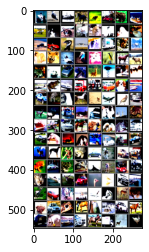

 ship  bird  ship horse   cat   car  frog  ship plane   dog   dog   dog   dog truck   dog   cat truck   car  bird plane   cat truck   dog plane   dog   dog  ship  bird   dog  bird horse  deer  frog  ship   car plane  deer plane   cat   dog plane  frog  ship truck truck   car   dog plane   car   dog   cat horse  deer plane  bird truck  deer  deer   car  bird   car   dog  ship  frog  ship plane  ship horse  deer   dog   cat plane   car horse  deer   cat   car  ship horse   car  deer   dog  frog  frog   car   dog   car truck  frog   car  frog  frog plane   dog   car truck   cat  ship  deer   car  bird  bird   car  ship  deer   car  deer  ship plane horse  deer   cat  frog   car  frog horse  bird  deer   car horse truck   dog  ship   car horse truck  deer  bird


In [3]:
import matplotlib.pyplot as plt


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(128)))

### 1.2 Model definition.

Now we have the data ready, the next step is to define the model that we want to train on these data. Since CIFAR10 is a small dataset, we'll just build a very simple Convolutional Neural Network for our problem. The architecture of it will be (in order):

* 2D convolution: output feature channel number = 6, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* 2D convolution: output feature channel number = 16, kernel size = 5x5, stride = 1, no padding;
* 2D max pooling: kernel size = 2x2, stride = 2;
* Fully-connected layer: output feature channel number = 120;
* Fully-connected layer: output feature channel number = 84;
* Fully-connected layer: output feature channel number = 10 (number of classes).

Implement the `__init__()` and `forward()` functions in `network.py`. As a good practice, `__init__()` generally defines the network architecture and `forward()` takes the runtime input `x` and passes through the network defined in `__init__()`, and returns the output.

In [4]:
from network import Net

net = Net()

### 1.3 Loss and optimizer definition.

Okay we now have the model too! The next step is to train the model on the data we have prepared. But before that , we first need to define a loss function and an optimization procedure, which specifies how well our model does and how the training process is carried out, respectively. We'll be using Cross Entropy loss as our loss function and Stochastic Gradient Descent as our optimization algorithm. We will not cover them in detail here but you are welcome to read more on it. ([this article](https://cs231n.github.io/neural-networks-2/) and [this article](https://cs231n.github.io/optimization-1/) from CS231n would be a great point to start). 

PyTorch implements very convenient interfaces for loss functions and optimizers, which we have put for you below.

In [5]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

### 1.4 Kick start training.

What we have done so far prepares all the necessary pieces for actual training, and now let's kick start the training process! Running this training block should take several minutes on your CPU.

In [6]:
epoch_num = 30
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %3d] loss: %.3f, acc: %.3f%% (%d/%d)' %
                  (epoch + 1, i + 1, running_loss / 100, 100. * correct / total, correct, total))
            running_loss = 0.0

    scheduler.step()

    # print('[Epoch %d] loss: %.3f, acc: %.3f%% (%d/%d)' %
    #       (epoch + 1, running_loss, 100. * correct / total, correct, total))

print('Finished Training')

[1, 100] loss: 1.777, acc: 34.258% (4385/12800)
[1, 200] loss: 1.446, acc: 40.426% (10349/25600)
[1, 300] loss: 1.307, acc: 44.562% (17112/38400)
[2, 100] loss: 1.101, acc: 60.320% (7721/12800)
[2, 200] loss: 1.056, acc: 61.223% (15673/25600)
[2, 300] loss: 0.970, acc: 62.622% (24047/38400)
[3, 100] loss: 0.844, acc: 69.789% (8933/12800)
[3, 200] loss: 0.841, acc: 69.965% (17911/25600)
[3, 300] loss: 0.808, acc: 70.458% (27056/38400)
[4, 100] loss: 0.719, acc: 74.727% (9565/12800)
[4, 200] loss: 0.711, acc: 74.883% (19170/25600)
[4, 300] loss: 0.695, acc: 75.036% (28814/38400)
[5, 100] loss: 0.641, acc: 77.562% (9928/12800)
[5, 200] loss: 0.627, acc: 77.723% (19897/25600)
[5, 300] loss: 0.642, acc: 77.638% (29813/38400)
[6, 100] loss: 0.573, acc: 80.180% (10263/12800)
[6, 200] loss: 0.566, acc: 80.180% (20526/25600)
[6, 300] loss: 0.575, acc: 80.008% (30723/38400)
[7, 100] loss: 0.513, acc: 82.031% (10500/12800)
[7, 200] loss: 0.515, acc: 81.910% (20969/25600)
[7, 300] loss: 0.529, acc

The last step of training is to save the trained model locally to a checkpoint:

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 1.5 Test the trained model on the test data.

Remember earlier we split the data into training and testing set? Now we'll be using the testing split to see how our model performs on unseen data. We'll check this by predicting the class label that the neural network outputs, and comparing it against the ground-truth.

Let's first examine some data from the testing set:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


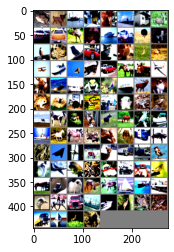

GroundTruth:   frog   dog  ship  deer


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Now, let's load in our saved model checkpoint and get its output:

In [9]:
# load in model checkpoint
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
# First, get the output from the model by passing in `images`;
# Next, think about what the model outputs mean / represent, and convert it to the predicted class index (`predicted`);
# Finally, output the predicted class label (already done for you).

predicted = []
### YOUR CODE HERE
outputs = net(images)
_, predicted_ = torch.max(outputs, 1)
predicted = predicted_.tolist()
### END YOUR CODE
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(100)))

Predicted:   frog   dog  ship   cat   cat  ship truck  bird   car   car  bird  frog  ship truck  bird   cat  bird  frog  bird   car   cat   cat  bird  deer plane   car  bird   cat   car horse horse plane   dog  deer  ship  frog  bird  ship  deer   cat  frog   dog   cat  deer   car   dog  frog  bird  deer horse  frog   cat   dog horse  bird  ship  ship horse horse  frog   dog   dog truck plane  frog plane plane  deer  deer truck   car  bird  bird plane  bird  frog   dog   car truck  frog horse truck   dog  deer  deer  ship  ship truck  bird horse truck  ship  ship  frog  frog  frog truck  ship  deer  deer


Besides inspecting these several examples, let's also look at how the network performs on the entire testing set by calculating the percentage of correctly classified examples.

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Similar to the previous question, calculate model's output and the percentage as correct / total
        ### YOUR CODE HERE
        outputs = net(images)
        _, predicted_ = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted_ == labels).sum().item()
        ### END YOUR CODE

print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

Accuracy of the network on the 10000 test images: 86 %


What accuracy did you get? Compared to random guessing, does your model perform significantly better?

**You answer here:** Write your answer in this markdown cell.   
I got 57%, which indicated much preciser than random guessing with an accuracy of 10%.    
But it's still far from satisfaction, some extra fine-tuing methods could be done and push the progress further.


Let's do some analysis to gain more insights of the results. One analysis we can carry out is the accuracy for each class, which can tell us what classes our model did well, and what classes our model did poorly.

In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # repeat what you did previously, but now for each class
        ### YOUR CODE HERE
        outputs = net(images)
        _, predicted_ = torch.max(outputs, 1)
        for i in range(len(predicted_)):
            total_pred[classes[labels[i]]] += 1
            if predicted_[i] == labels[i]:
                correct_pred[classes[labels[i]]] += 1
        ### END YOUR CODE

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                         accuracy))

Accuracy for class plane is: 88.7 %
Accuracy for class car   is: 94.8 %
Accuracy for class bird  is: 80.2 %
Accuracy for class cat   is: 75.7 %
Accuracy for class deer  is: 85.2 %
Accuracy for class dog   is: 78.7 %
Accuracy for class frog  is: 90.5 %
Accuracy for class horse is: 87.1 %
Accuracy for class ship  is: 91.9 %
Accuracy for class truck is: 92.0 %


### 1.6 Hyper-parameter tuning.

An important phase in deep learning framework is hyper-parameter search. Hyper-parameters generally refer to those parameters that are **not** automatically optimized during the learning process, e.g., model architecture, optimizer, learning rate, batch size, training length, etc. Tuning these hyper-parameters could often lead to significant improvement of your model performance.

Your job in this section is to identify the hyper-parameters and tune them to improve the model performance. You might want to refer to PyTorch documentation or other online resources to gain an understanding of what these hyper-parameters mean. Some of the options you might want to look into are:
* Model architecture (number of layers, layer size, feature number, etc.);
* Loss and optimizer (including loss function, regularization, learning rate, learning rate decay, etc.);
* Training configuration (batch size, epoch number, etc.).
These are by no means a complete list, but is supposed to give you an idea of the hyper-parameters. You are encouraged to identify and tune more.

Report in detail what you did in this section. Which of them improved model performance, and which did not?

**You answer here:** Write your answer in this markdown cell.   
1. At the very beginning, the accuracy was 57%.
2. Then I added **activate function** after every layer, the accuracy rose to 62%.
3. Notice that **data augmentation** is also available. `transforms.RandomCrop()` and `transforms.RandomHorizontalFlip()` were then used, but no obvious difference found.
4. Keep observe the dataset, modify the normalization step.
5. Make `batch_size` and `epoch` larger to its optimal performance, making the accuracy rise to 64%.
But the accuracy is still not good enough. The root cause might be too-simple network structure.
6. Completely rewrite the model, transforming LeNet to VGG-16.
7. The final accuracy is 84%, which is relevantly acceptable.